In [ ]:
!pip install tensorflow tensorflow-gpu opencv-python matplotlib

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
import os
pixelated_dir = '/content/drive/MyDrive/PrasoonCodes/dataset/Pixelated'
clear_dir = '/content/drive/MyDrive/PrasoonCodes/dataset/Non-Pixelated'
batch_size = 32
img_height = 500
img_width = 500

# Create datasets for pixelated and clean images
noisy_ds = tf.keras.utils.image_dataset_from_directory(
    pixelated_dir,
    labels=None,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)

clean_ds = tf.keras.utils.image_dataset_from_directory(
    clear_dir,
    labels=None,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
)



Found 165 files belonging to 1 classes.
Found 165 files belonging to 1 classes.


In [ ]:
# Combine noisy and clean datasets
train_ds = tf.data.Dataset.zip((noisy_ds, clean_ds))

# Define preprocessing function
def preprocess(noisy, clean):
    # Normalize pixel values to [0, 1]
    noisy = tf.cast(noisy, tf.float32) / 255.0
    clean = tf.cast(clean, tf.float32) / 255.0
    return noisy, clean

# Apply preprocessing
train_ds = train_ds.map(preprocess)

# Split into train and validation sets
val_ds = train_ds.take(len(train_ds) // 5)
train_ds = train_ds.skip(len(train_ds) // 5)


# Use buffered prefetching
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)



In [ ]:
#EAM
class EAM(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.conv1 = layers.Conv2D(64, (3,3), dilation_rate=1, padding='same', activation='relu')
        self.conv2 = layers.Conv2D(64, (3,3), dilation_rate=2, padding='same', activation='relu')
        self.conv3 = layers.Conv2D(64, (3,3), dilation_rate=3, padding='same', activation='relu')
        self.conv4 = layers.Conv2D(64, (3,3), dilation_rate=4, padding='same', activation='relu')
        self.conv5 = layers.Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv6 = layers.Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv7 = layers.Conv2D(64, (3,3), padding='same')
        self.conv8 = layers.Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv9 = layers.Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv10 = layers.Conv2D(64, (1,1), padding='same')
        self.gap = layers.GlobalAveragePooling2D()
        self.conv11 = layers.Conv2D(64, (3,3), padding='same', activation='relu')
        self.conv12 = layers.Conv2D(64, (3,3), padding='same', activation='sigmoid')

    def call(self, inputs):
        conv1 = self.conv2(self.conv1(inputs))
        conv2 = self.conv4(self.conv3(inputs))

        concat = layers.Concatenate()([conv1, conv2])
        conv3 = self.conv5(concat)
        add1 = layers.Add()([inputs, conv3])

        conv4 = self.conv7(self.conv6(add1))
        add2 = layers.Add()([conv4, add1])
        add2 = layers.Activation('relu')(add2)

        conv5 = self.conv10(self.conv9(self.conv8(add2)))
        add3 = layers.Add()([add2, conv5])
        add3 = layers.Activation('relu')(add3)

        gap = layers.Reshape((1,1,64))(self.gap(add3))
        conv6 = self.conv12(self.conv11(gap))

        mul = layers.Multiply()([conv6, add3])
        out = layers.Add()([inputs, mul])
        return out


In [ ]:

# Model
tf.keras.backend.clear_session()
input_layer = tf.keras.Input(shape=(500, 500, 3))

conv1 = layers.Conv2D(64, (3,3), padding='same')(input_layer)
eam1 = EAM()(conv1)
eam2 = EAM()(eam1)
eam3 = EAM()(eam2)
eam4 = EAM()(eam3)
conv2 = layers.Conv2D(3, (3,3), padding='same')(eam4)
out = layers.Add()([conv2, input_layer])

RIDNet = tf.keras.Model(inputs=input_layer, outputs=out)
RIDNet.compile(
    optimizer=tf.keras.optimizers.Adam(1e-03),
    loss=tf.keras.losses.MeanSquaredError())


In [ ]:
RIDNet.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 500, 500, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 500, 500, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 eam (EAM)                   (None, 500, 500, 64)         447232    ['conv2d[0][0]']              
                                                                                                  
 eam_1 (EAM)                 (None, 500, 500, 64)         447232    ['eam[0][0]']                 
                                                                                              

In [ ]:
#training
epochs=10
history = RIDNet.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


1/1 [==============================] - 20s 20s/step


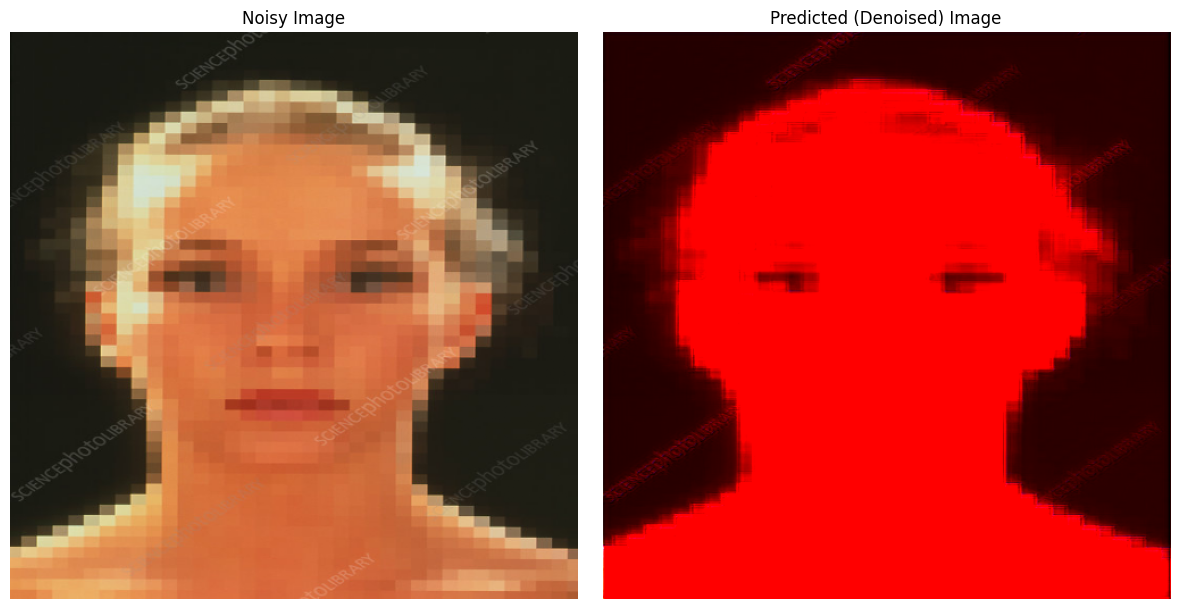

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def load_and_preprocess_image(image_path, target_size=(500, 500)):
    # Load the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, target_size)

    # Normalize pixel values to [0, 1]
    img = tf.cast(img, tf.float32) / 255.0

    # Add batch dimension
    img = tf.expand_dims(img, 0)

    return img

def generate_predicted_image(model, noisy_image_path):
    # Load and preprocess the noisy image
    noisy_img = load_and_preprocess_image(noisy_image_path)

    # Generate the prediction
    predicted_img = model.predict(noisy_img)

    # Remove the batch dimension and clip values to [0, 1]
    predicted_img = np.clip(predicted_img[0], 0, 1)

    return predicted_img

# Path to your noisy image
noisy_image_path = '/content/M2450164.jpg'

# Generate the predicted image
predicted_img = generate_predicted_image(RIDNet, noisy_image_path)

# Display the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(load_and_preprocess_image(noisy_image_path)[0])
ax1.set_title('Pixelated Image')
ax1.axis('off')

ax2.imshow(predicted_img)
ax2.set_title('Predicted (Denoised) Image')
ax2.axis('off')

plt.tight_layout()
plt.show()

plt.imsave('predicted_image.png', predicted_img)